Replicating: https://github.com/fastai/fastai/blob/master/courses/dl1/lesson2-image_models.ipynb
        
## Multi-label Classification

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *

In [3]:
PATH = "data/planet/"

In [8]:
!ls {PATH}

download      ReadMe.md			test-jpg-additional	  train-jpg
fastai_broke  sample_submission_v2.csv	test_v2_file_mapping.csv  train_v2.csv
models	      test-jpg			tmp


## 2 Multi-Label versus Single-Label Classification

In [4]:
from fastai.plots import *

In [6]:
def get_1st(path): return glob(f'{path}/*.*')[0]

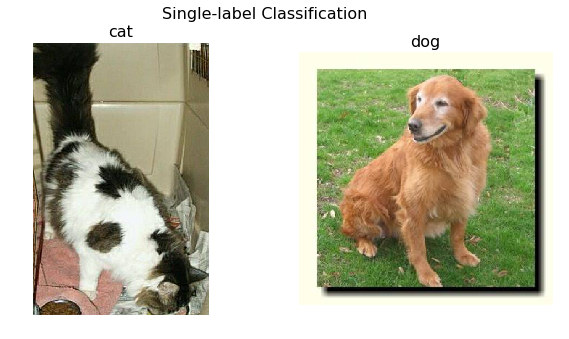

In [7]:
dc_path = "data/dogscats/valid/"
list_paths = [get_1st(f"{dc_path}cats"), get_1st(f"{dc_path}dogs")]
plots_from_files(list_paths, titles=["cat", "dog"], maintitle="Single-label Classification")

In single-label classification each sample belongs to one class. In the previous example, each image is either a dog *or* a cat.

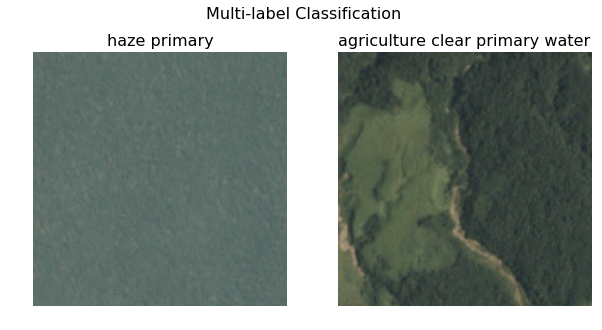

In [8]:
list_paths = [f"{PATH}train-jpg/train_0.jpg", f"{PATH}train-jpg/train_1.jpg"]
titles = ["haze primary", "agriculture clear primary water"]
plots_from_files(list_paths, titles=titles, maintitle="Multi-label Classification")

Softmax wouldn't be good because it wants to "pick *a* thing". Instead, we'll use the Sigmoid. In multi-label clsfn, each sample can belong to one or more classes. In the previous example, the 1st images belong to two classes: *haze* and *primary*. The 2nd belongs to four classes: *agriculture, clear, primary,* and *water*.

## 3 Multi-Label Models for Planet Dataset

fastai is baller AF bc it'll look at the labels in the CSV, and if there're `> 1` labels *ever*, for any item, it'll automatically switch to multi-label mode.

In [5]:
from planet import f2

metrics = [f2]
f_model = resnet34

In [6]:
label_csv = f'{PATH}train_v2.csv'
n = len(list(open(label_csv)))-1
val_idxs = get_cv_idxs(n, cv_idx=4) # using cv_idx=4 to keep same permutation as orig. notebook

We use a different set of DAs for this dataset -- we also allow vertical flips, since we don't expect the vertical orientation of satellite images to change our classifications.

In [7]:
def get_data(sz,bs=64):
    tfms = tfms_from_model(f_model, sz, aug_tfms=transforms_top_down, max_zoom=1.05)
    return ImageClassifierData.from_csv(PATH, 'train-jpg', label_csv, tfms=tfms, bs=bs,
                                        suffix='.jpg', val_idxs=val_idxs, test_name='test-jpg')

In [12]:
data = get_data(256) # the planet images are 256x256

In [13]:
# turning a dataloader into an iterator:
x,y = next(iter(data.val_dl)) # note: .._ds: dataset; .._dl: dataloader | PyTorch concepts
# idea: dataset gives you a single image or object back
#       dataloader gives you back a single (transformed) mini-batch (next mini-batch only)

In [14]:
y    # 64x17: batch size x number of classes


    1     0     0  ...      0     1     1
    0     0     0  ...      0     0     0
    0     0     0  ...      0     0     0
       ...          ⋱          ...       
    0     0     0  ...      0     0     0
    0     0     0  ...      0     0     0
    1     0     0  ...      0     0     0
[torch.FloatTensor of size 64x17]

In [15]:
# zip, basically zips two lists together into an iterator
list(zip(data.classes, y[0])) # getting the 0th image's labels -- from validation set

[('agriculture', 1.0),
 ('artisinal_mine', 0.0),
 ('bare_ground', 0.0),
 ('blooming', 0.0),
 ('blow_down', 0.0),
 ('clear', 1.0),
 ('cloudy', 0.0),
 ('conventional_mine', 0.0),
 ('cultivation', 0.0),
 ('habitation', 0.0),
 ('haze', 0.0),
 ('partly_cloudy', 0.0),
 ('primary', 1.0),
 ('road', 0.0),
 ('selective_logging', 0.0),
 ('slash_burn', 1.0),
 ('water', 1.0)]

Behind the scenes, FastAI & PyTorch are turning our labels into 1-Hot Encoded Labels.

Storing 1H-Encs as separate arrays is v.inefficient, instead the index values of positive-encodings are used, although the actual 1H-Enc vectors are dealt w/ deep in PyTorch.

In [16]:
# data.val_ds.fnames[:15]

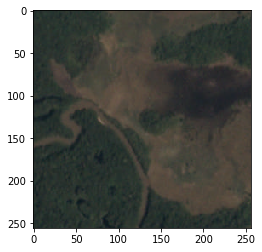

In [17]:
plt.imshow(data.val_ds.get_x(0))

Images are just matrices of numbers, so we can just multiply them by a number if they're too washed out / hazy:

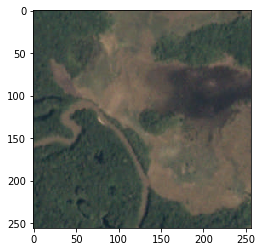

In [18]:
plt.imshow(data.val_ds.denorm(to_np(x))[0]*1.4);
# NOTE: same as: plt.imshow(data.val_ds.get_x(0) * 1.4)

From here on, we just proceed as normal.

What's interesting about this dataset is it's nothing like ImageNet.

The first thing we do is resize the data to `64 x 64`. The data starts out as `256 x 256`. You wouldn't want to do this for the DogsCats competition because the pretrained models start out almost perfect for them (being trained on similarly-sized ImageNet images). If we resized to `64 x 64` and then retrained the entire network: we'd essentially destroy the weights that were already pretrained to be v.good. Most ImageNet-trained models are trained at `224 x 224` or `299 x 299`.

However there's no satellite imagery in ImageNet. So only the earlier Conv layers are going to be useful to us -- edges, gradients, repeating patterns, etc.

Starting out by training smaller images tends to work well for satellite images -- coming from an ImageNet-pretrained model.

In [19]:
sz = 64 # resize to 64x64
data = get_data(sz)  # grab data
data = data.resize(int(sz*1.3), 'tmp') # <-- this line not necessary

HBox(children=(IntProgress(value=0, max=6), HTML(value='')))

A **NOTE** on the `data.resize(int(sz*1.3), 'tmp')` line above. The dataloader only resizes images when it outputs them to the model --> the images go into the dataloader at full size. The `data.resize(.)` method takes a maximum size (here `int(64 * 1.3) = 83`) and creates a resized copy of the entire dataset to a temporary folder. This technique is purely a speed-up measure, with no actual effect on model performace. ... But very handy in practice when you think about it... good to know..

http://forums.fast.ai/t/dog-breed-identification-challenge/7464/51

http://forums.fast.ai/t/deeplearning-lecnotes3/7866

In [20]:
learn = ConvLearner.pretrained(f_model, data, metrics=metrics) # build the model

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

[ 0.       0.22486  0.39508  0.78313]                        



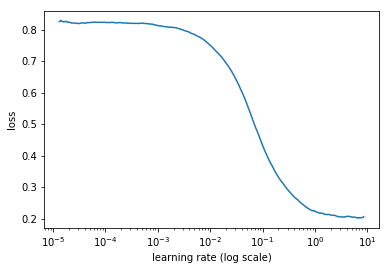

In [22]:
learn.lr_find()
learn.sched.plot()

The optimal starting learning rates turns out to be quite high: `O(1e0) to O(1e-1)`

Because the dataset is so unlike ImageNet, we'll have to do quite a bit of fitting of the last layer -- do that until it starts to flatten out.

Another difference from ImageNet-like datasets: instead of Dfntl LRs differing by orders of magnitude (λr÷100, λr÷10, λr), we use a much more aggressive Dfntl of 3: (λr÷9, λr÷3, λr)

With the idea being: the earlier layers are not as close to what they need to be compared to the ImageNet-like datasets.

Then we unfreeze and train for a while:

In [13]:
lr = 0.2

In [24]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

[ 0.       0.14461  0.13248  0.88255]                        
[ 1.       0.14497  0.12755  0.88886]                        
[ 2.       0.13995  0.12575  0.88993]                        
[ 3.       0.14377  0.12554  0.88967]                        
[ 4.       0.1352   0.12311  0.89259]                        
[ 5.       0.13632  0.12144  0.89545]                        
[ 6.       0.13242  0.12074  0.89545]                        



In [14]:
lrs = np.array([lr/9, lr/3, lr])

In [26]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

[ 0.       0.121    0.10967  0.90602]                        
[ 1.       0.11459  0.10329  0.91285]                        
[ 2.       0.10774  0.10069  0.91464]                        
[ 3.       0.11161  0.10377  0.91143]                        
[ 4.       0.10667  0.09973  0.91435]                        
[ 5.       0.10114  0.0976   0.91747]                         
[ 6.       0.09907  0.09595  0.91986]                         



In [27]:
learn.save(f'{sz}')

We can see the loss-spikes at the start of each SGDR cycle:

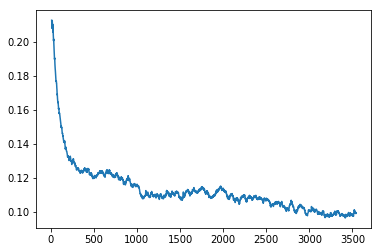

In [28]:
learn.sched.plot_loss()

Now we increase (double here) the size of our images and train again:

In [29]:
sz = 128

In [30]:
learn.set_data(get_data(sz))
learn.freeze()
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

[ 0.       0.09888  0.09269  0.92082]                         
[ 1.       0.09893  0.09152  0.92192]                         
[ 2.       0.09709  0.0916   0.92171]                         
[ 3.       0.09584  0.09168  0.92173]                         
[ 4.       0.09606  0.09033  0.92317]                         
[ 5.       0.09502  0.08979  0.92441]                         
[ 6.       0.09576  0.08962  0.92412]                         



In [31]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)
learn.save(f'{sz}')

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

[ 0.       0.09282  0.08549  0.92958]                         
[ 1.       0.09459  0.08758  0.9267 ]                         
[ 2.       0.0854   0.08459  0.929  ]                         
[ 3.       0.09304  0.08844  0.92379]                         
[ 4.       0.08719  0.0846   0.93018]                         
[ 5.       0.08373  0.08299  0.93084]                         
[ 6.       0.08284  0.08415  0.93024]                         



Double image size again (finally up to original size) & repeat:

In [12]:
??learn.save

In [33]:
learn.save(f'{sz}_unfrozen')

---

<<< Restarted Notebook -- Loading saved Weights >>>>

I thought my weights were deleted for a while there. For some reason the file `128_unfrozen.h5` was saved to `{PATH}/tmp/83/models/` instead of to `{PATH}/models/`. Is the FastAI library setting its current working directory to the temporary images folder after `data.resize(.)`?

I'll just move the models folder up to where it should be and carry on as normal.

In [11]:
data = get_data(sz = 128)
learn = ConvLearner.pretrained(f_model, data, metrics=metrics)
learn.load(f'128_unfrozen')

In [9]:
sz = 256

In [28]:
learn.set_data(get_data(sz))
learn.freeze()
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

[ 0.       0.091    0.08723  0.92623]                         
[ 1.       0.08808  0.08571  0.92747]                         
[ 2.       0.08908  0.08575  0.92794]                         
[ 3.       0.09243  0.08569  0.92773]                         
[ 4.       0.09005  0.08471  0.92902]                         
[ 5.       0.08776  0.08539  0.92803]                         
[ 6.       0.08771  0.08515  0.92771]                         



In [29]:
learn.save(f'{sz}')
learn.data.bs = 32

In [13]:
learn.load(f'256')
learn.set_data(get_data(sz, bs=24))

In [10]:
# restarting after a network error
data = get_data(sz, bs=24)
learn = ConvLearner.pretrained(f_model, data, metrics=metrics)
learn.load(f'256')

In [17]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)
learn.save(f'{sz}')

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

[ 0.       0.09443  0.08587  0.93107]                           
[ 1.       0.09462  0.08487  0.93524]                           
[ 2.       0.09106  0.08341  0.9336 ]                            
[ 3.       0.10047  0.08912  0.92656]                             
[ 4.       0.0907   0.08446  0.93324]                             
[ 5.       0.08577  0.08188  0.93432]                            
[ 6.       0.08659  0.08121  0.93456]                             



Finally predict with Test Time Augmentation (this is on validation data)

In [18]:
tta = learn.TTA()

In [19]:
f2(*tta)

0.93381255732233426

This approach gets up to 50th place on the Kaggle Planet Amazon competition! A competition full of machine-learning / data-scientist wizards. Hail RoboLord. Hail. ..But seriously, better tools are awesome.

### 3.1 END

---

In [1]:
# reloading everything in one cell after dead kernel:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
PATH = "data/planet/"
from fastai.plots import *
from planet import f2

metrics = [f2]
f_model = resnet34

label_csv = f'{PATH}train_v2.csv'
# n = len(list(open(label_csv)))-1
# val_idxs = get_cv_idxs(n, cv_idx=4)
val_idxs = [0]

def get_data(sz,bs=64):
    tfms = tfms_from_model(f_model, sz, aug_tfms=transforms_top_down, max_zoom=1.05)
    return ImageClassifierData.from_csv(PATH, 'train-jpg', label_csv, tfms=tfms, bs=bs,
                                        suffix='.jpg', val_idxs=val_idxs, test_name='test-jpg')

data = get_data(sz=256)
learn = ConvLearner.pretrained(f_model, data, metrics=metrics)
learn.load(f'256')

In [3]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 256, 256]),
                           ('output_shape', [-1, 64, 128, 128]),
                           ('trainable', False),
                           ('nb_params', 9408)])),
             ('BatchNorm2d-2',
              OrderedDict([('input_shape', [-1, 64, 128, 128]),
                           ('output_shape', [-1, 64, 128, 128]),
                           ('trainable', False),
                           ('nb_params', 128)])),
             ('ReLU-3',
              OrderedDict([('input_shape', [-1, 64, 128, 128]),
                           ('output_shape', [-1, 64, 128, 128]),
                           ('nb_params', 0)])),
             ('MaxPool2d-4',
              OrderedDict([('input_shape', [-1, 64, 128, 128]),
                           ('output_shape', [-1, 64, 64, 64]),
                           ('nb_params', 0)])),
             ('Conv2d-5',
              OrderedDict([('input_shape', [-1, 64, 64, 

In [4]:
learn.data.sz

256

In [4]:
# It seems this is still necessary despite similar problems solved in this issue:
# https://github.com/fastai/fastai/issues/23
import resource
rlimit = resource.getrlimit(resource.RLIMIT_NOFILE)
resource.setrlimit(resource.RLIMIT_NOFILE, (4096, rlimit[1]))

In [8]:
test_log_preds = learn.TTA(is_test=True)
# test_preds = np.exp(test_log_preds)

In [24]:
# cut off the unneeded Zero labels
test_log_preds = test_log_preds[0]

In [25]:
test_preds = np.exp(test_log_preds)

In [31]:
data.classes

['agriculture',
 'artisinal_mine',
 'bare_ground',
 'blooming',
 'blow_down',
 'clear',
 'cloudy',
 'conventional_mine',
 'cultivation',
 'habitation',
 'haze',
 'partly_cloudy',
 'primary',
 'road',
 'selective_logging',
 'slash_burn',
 'water']

In [32]:
data.test_ds.fnames[:10]

['test-jpg/test_26652.jpg',
 'test-jpg/test_7690.jpg',
 'test-jpg/test_5862.jpg',
 'test-jpg/test_7729.jpg',
 'test-jpg/test_20034.jpg',
 'test-jpg/test_22291.jpg',
 'test-jpg/test_36838.jpg',
 'test-jpg/test_7880.jpg',
 'test-jpg/test_32275.jpg',
 'test-jpg/test_36084.jpg']

In [34]:
x = 'test-jpg/test_26652.jpg'

In [41]:
print(x)
print(x.split('/'))
print(x.split('/')[1])
print(x.split('/')[1].split('.')[0])

test-jpg/test_26652.jpg
['test-jpg', 'test_26652.jpg']
test_26652.jpg
test_26652


Submission format:

```
image_name,tags
test_0,agriculture road water
test_1,primary clear
test_2,haze primary
etc.```

In [49]:
test_preds[5]

array([ 1.57553,  1.00024,  1.00778,  1.00181,  1.00095,  2.7148 ,  1.00004,  1.00044,  1.05202,  1.0093 ,
        1.00069,  1.00064,  2.71679,  2.15852,  1.01099,  1.00174,  1.49312], dtype=float32)

In [101]:
arr = [chr(ord('ა') + i) for i in range(10)]
' '.join(arr)

'ა ბ გ დ ე ვ ზ თ ი კ'

In [67]:
arr = [chr(ord('a') + i) for i in range(10)]
num = [i % 2 for i in range(10)]

print(arr)
print(idxs)

# NOTE: np.where(.) needs NumPy arrays!
arr = np.array(arr)
num = np.array(num)

print(arr[np.where(num==1)])

['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j']
[0, 1, 0, 1, 0, 1, 0, 1, 0, 1]
['b' 'd' 'f' 'h' 'j']


In [78]:
temp = np.array([i % 2 for i in range(6)])
classes = np.array(data.classes)
classes[np.where(temp==1)]

array(['artisinal_mine', 'blooming', 'clear'],
      dtype='<U17')

Looking at `test_preds` I'm noticing a base value of 1.0 and predictions that go up from there to, I think, a max of around 2.0. Judging by that and tips in [this fastai thread](http://forums.fast.ai/t/planet-classification-challenge/7824/90): I'll set a threshold of 1.02 and anything higher than that will be a positive match.

I don't know why my predictions are starting from 1 and not zero, if I did something wrong or if it's just like that.

In [102]:
threshold = 1.02
classes = np.array(data.classes)
predicted_tags = [[' '.join(classes[np.where(pred >= threshold)])] for pred in test_preds]

In [104]:
submission = pd.DataFrame(predicted_tags)
submission.columns = ['tags']

In [106]:
submission.insert(0, 'image_name', [f.split('/')[1].split('.')[0] for f in data.test_ds.fnames])
submission.head()

,image_name,tags
0,test_26652,cloudy haze partly_cloudy primary
1,test_7690,agriculture clear cultivation primary
2,test_5862,agriculture partly_cloudy primary water
3,test_7729,agriculture clear cultivation habitation prima...
4,test_20034,clear haze primary


In [107]:
# for single-class; won't work here
# submission = pd.DataFrame(test_preds)
# submission.columns = data.classes
# submission.insert(0, 'id', [f.split('/')[1].split('.')[0] for f in data.test_ds.fnames])

In [108]:
SUBM = PATH + 'subm/'
os.makedirs(SUBM, exist_ok=True)

In [110]:
submission.to_csv(f'{SUBM}FADL1-L3CA-submission-RN34-00.csv.gz', compression='gzip', index=False)

In [111]:
# FileLink(f'{SUBM}FADL1-L3CA-submission-RN34-00.csv.gz')

/home/wnixalo/Kaukasos/FADL1/data/planet/subm/FADL1-L3CA-submission-RN34-00.csv.gz

---

I made a mistake here. I didn't add the additional test set images. Will do that below. Not sure if there's a cleaner way to add more test data in fastai:

In [113]:
# does tfms matter since I'm only adding another test-set ?
tfms = tfms_from_model(f_model, sz=256, aug_tfms=transforms_top_down, max_zoom=1.05)
data = ImageClassifierData.from_csv(PATH, 'train-jpg', label_csv, tfms=tfms, bs=24, suffix='.jpg', 
                                    val_idxs=val_idxs, test_name='test-jpg-additional')
learn.set_data(data)

In [114]:
log_preds_adtl = learn.TTA(is_test=True)[0]
preds_adtl = np.exp(log_preds_adtl)

In [117]:
data.test_ds.fnames[0]

'test-jpg-additional/file_7218.jpg'

In [118]:
predicted_tags_adtl = [[' '.join(classes[np.where(pred >= threshold)])] for pred in preds_adtl]
df_adtl = pd.DataFrame(predicted_tags_adtl, columns = ['tags'])

df_adtl.insert(0, 'image_name', [f.split('/')[1].split('.')[0] for f in data.test_ds.fnames])

In [119]:
df_adtl.head()

,image_name,tags
0,file_7218,partly_cloudy primary water
1,file_14698,agriculture clear cultivation haze primary
2,file_15351,agriculture clear cultivation habitation haze ...
3,file_19516,clear primary
4,file_12116,agriculture clear cultivation primary slash_burn


Pandas DataFrame appending: [Docs λink](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.append.html)

In [120]:
submission.append(df_adtl)

,image_name,tags
0,test_26652,cloudy haze partly_cloudy primary
1,test_7690,agriculture clear cultivation primary
2,test_5862,agriculture partly_cloudy primary water
3,test_7729,agriculture clear cultivation habitation prima...
4,test_20034,clear haze primary
5,test_22291,agriculture clear cultivation primary road water
6,test_36838,clear primary water
7,test_7880,clear primary
8,test_32275,agriculture clear cloudy haze primary water
9,test_36084,partly_cloudy primary


In [133]:
submission.shape

(40669, 2)

So append doesn't automatically change what you're appending to.

In [134]:
submission = submission.append(df_adtl)

In [130]:
x, y = 'a', 'b'
f'{x,y}', f'{x}{y}'

("('a', 'b')", 'ab')

In [135]:
subm_name = "FADL1-L3CA-submission-RN34-00"
submission.to_csv(f'{SUBM}{subm_name}.csv.gz', compression='gzip', index=False)

In [136]:
FileLink(f'{SUBM}{subm_name}.csv.gz')

/home/wnixalo/Kaukasos/FADL1/data/planet/subm/FADL1-L3CA-submission-RN34-00.csv.gz

___

Submissino `FADL1-L3CA-submission-RN34-00` scored **0.88148 -- 616/938** Private.

Saving raw log predictions incase I try to tweak thresholds later:

In [139]:
len(test_log_preds), len(log_preds_adtl)

(40669, 20522)

In [144]:
pd.DataFrame(test_log_preds, columns=data.classes).to_feather(f'{SUBM}test_log_preds.feather')
pd.DataFrame(log_preds_adtl, columns=data.classes).to_feather(f'{SUBM}test_log_preds_adtl.feather')

Tweaking thresholds and seeing if that changes things:

In [146]:
temp = pd.read_feather(f'{SUBM}test_log_preds.feather')

In [147]:
temp.head()

,agriculture,artisinal_mine,bare_ground,blooming,blow_down,clear,cloudy,conventional_mine,cultivation,habitation,haze,partly_cloudy,primary,road,selective_logging,slash_burn,water
0,0.000712,0.000014,0.000022,0.000113,0.000061,0.010569,0.026576,0.000052,0.000197,0.000217,0.144926,0.702607,0.972763,0.000144,0.000055,0.000016,0.004804
1,0.219001,0.000049,0.004751,0.001038,0.002235,0.997372,0.000124,0.000063,0.309076,0.002716,0.002209,0.001605,0.999789,0.001687,0.001068,0.004486,0.004914
2,0.047594,0.000076,0.000613,0.000404,0.000433,0.000130,0.018355,0.000097,0.006934,0.000452,0.000600,0.984635,0.976202,0.004502,0.000293,0.000452,0.041203
3,0.984426,0.000104,0.003751,0.000346,0.000151,0.997577,0.000137,0.000060,0.163502,0.353460,0.001001,0.001265,0.987649,0.356211,0.000206,0.003955,0.195996
4,0.005569,0.000036,0.000211,0.001392,0.000107,0.083440,0.002121,0.000076,0.007315,0.002841,0.900012,0.001055,0.997975,0.004283,0.000864,0.000141,0.004987


In [149]:
temp = temp.as_matrix();
type(temp)

numpy.ndarray

In [151]:
temp[0]

array([ 0.00071,  0.00001,  0.00002,  0.00011,  0.00006,  0.01057,  0.02658,  0.00005,  0.0002 ,  0.00022,
        0.14493,  0.70261,  0.97276,  0.00014,  0.00005,  0.00002,  0.0048 ], dtype=float32)

***Oh Shiiit.*** *Those* are Logarithmic Predictions?? Aha.. So.. I shouldn't've been exponentiating them in the first place: that explains why I had strange values. Right. So instead of needing a fancy function to iterate & test thresholds (which I can still do), I just need to make a submission of the log predictions. *Got it.*

In [153]:
log_preds_adtl[0]

array([ 0.00733,  0.00022,  0.00039,  0.0073 ,  0.00082,  0.00388,  0.00237,  0.0001 ,  0.00465,  0.00089,
        0.00133,  0.97957,  0.99828,  0.00193,  0.00246,  0.00045,  0.02409], dtype=float32)

In [158]:
a = [i for i in range(5)]; b = [-i for i in range(5)];
c = np.concatenate((a,b)); c

array([ 0,  1,  2,  3,  4,  0, -1, -2, -3, -4])

In [201]:
def get_data_2(test_name=None):
    label_csv = f'{PATH}train_v2.csv'
    f_model = resnet34
    tfms = tfms_from_model(f_model, sz=256, aug_tfms=transforms_top_down, max_zoom=1.05)
    return ImageClassifierData.from_csv(PATH, 'train-jpg', label_csv, bs=64, tfms=tfms,
                                        suffix='.jpg', val_idxs=[0], test_name=test_name)

def generate_submission(threshold=0.02):
    SUBM = PATH + 'subm/'
    test_log_preds = pd.read_feather(f'{SUBM}test_log_preds.feather').as_matrix()
    test_log_preds_adtl = pd.read_feather(f'{SUBM}test_log_preds_adtl.feather').as_matrix()
    
    data = get_data_2(test_name='test-jpg')
    fnames = data.test_ds.fnames
    data = get_data_2(test_name='test-jpg-additional')
    fnames = np.concatenate((fnames, data.test_ds.fnames))
    
    classes = np.array(data.classes)
    
    preds = np.concatenate((test_log_preds, test_log_preds_adtl))
    names = [f.split('/')[1].split('.')[0] for f in fnames]
    
    predicted_tags = [[' '.join(classes[np.where(pred >= threshold)])] for pred in preds]
    
    submission = pd.DataFrame(predicted_tags, columns=['tags'])
    submission.insert(0, 'image_name', names)
    return submission

In [202]:
submission = generate_submission(threshold=0.02)
submission.head()

,image_name,tags
0,test_26652,cloudy haze partly_cloudy primary
1,test_7690,agriculture clear cultivation primary
2,test_5862,agriculture partly_cloudy primary water
3,test_7729,agriculture clear cultivation habitation prima...
4,test_20034,clear haze primary


In [203]:
subm_name = "FADL1-L3CA-submission-RN34-01"
submission.to_csv(f'{SUBM}{subm_name}.csv.gz', compression='gzip', index=False)

FileLink(f'{SUBM}{subm_name}.csv.gz')

/home/wnixalo/Kaukasos/FADL1/data/planet/subm/FADL1-L3CA-submission-RN34-01.csv.gz

In [206]:
submission = generate_submission(threshold=0.03)
subm_name = "FADL1-L3CA-submission-RN34-04"
submission.to_csv(f'{SUBM}{subm_name}.csv.gz', compression='gzip', index=False)

FileLink(f'{SUBM}{subm_name}.csv.gz')

/home/wnixalo/Kaukasos/FADL1/data/planet/subm/FADL1-L3CA-submission-RN34-04.csv.gz

In [207]:
submission = generate_submission(threshold=0.035)
subm_name = "FADL1-L3CA-submission-RN34-05"
submission.to_csv(f'{SUBM}{subm_name}.csv.gz', compression='gzip', index=False)

FileLink(f'{SUBM}{subm_name}.csv.gz')

/home/wnixalo/Kaukasos/FADL1/data/planet/subm/FADL1-L3CA-submission-RN34-05.csv.gz

This scores: **0.90181 -- 517/938** Private, when using a threshold of `0.035` and Log predictions.

In [208]:
submission = generate_submission(threshold=0.04)
subm_name = "FADL1-L3CA-submission-RN34-06"
submission.to_csv(f'{SUBM}{subm_name}.csv.gz', compression='gzip', index=False)

FileLink(f'{SUBM}{subm_name}.csv.gz')

/home/wnixalo/Kaukasos/FADL1/data/planet/subm/FADL1-L3CA-submission-RN34-06.csv.gz

In [209]:
submission = generate_submission(threshold=0.045)
subm_name = "FADL1-L3CA-submission-RN34-07"
submission.to_csv(f'{SUBM}{subm_name}.csv.gz', compression='gzip', index=False)

FileLink(f'{SUBM}{subm_name}.csv.gz')

/home/wnixalo/Kaukasos/FADL1/data/planet/subm/FADL1-L3CA-submission-RN34-07.csv.gz

**0.90596 -- 488/938** Private, threshold of `0.045`

Oh.. hah ffs.. Looks like the optimal threshold was around 0.2, *not* 0.02 as I thought. [fastai link](http://forums.fast.ai/t/planet-classification-challenge/7824/90?u=borz). Well I used up my daily submits at this point -- will see how high this model can get in about 23 hours.